<p style="text-align: center; font-size: 300%"> Computational Finance </p>
<img src="img/ABSlogo.svg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">

In [1]:
#silence some warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting Basics
* Plotting in (scientific) Python is mostly done via the `matplotlib` library ([user guide](https://matplotlib.org/users/index.html)), which is inspired by the plotting facilities of Matlab&reg;.
* Its main plotting facilities reside in its `pyplot` module. It is usually imported as

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

* The second line is an [ipython magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html). It makes plots appear inline in the notebook.
* The `seaborn` library ([user guide](https://seaborn.pydata.org/tutorial.html)) provides higher-level statistical visualizations:

In [3]:
import seaborn as sns

* Finally, `statsmodels` is useful for QQ plots (see below):

In [4]:
import statsmodels.api as sm

* I will only give a brief introduction to matplotlib here. However, the code for all graphs shown below is included in the notebook (though sometimes hidden in slide mode), and should be studied.
* The fundamental object in matplotlib is a `figure`, inside of which reside `subplots` (or `axes`).
* To create a new figure, add an axis, and plot to it:

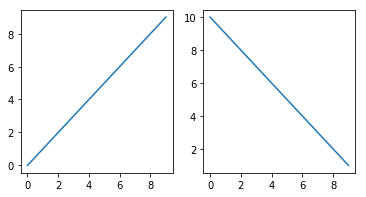

In [5]:
#With the inline backend, these need to be in the same cell.
fig = plt.figure(figsize=(6,3))  #Create a new empty figure object. Size is optional.
ax1 = fig.add_subplot(121)  #Layout: (1x2) axes. Add one in row 1, column 1, and make it current (what plt.* commands operate on).
ax2 = fig.add_subplot(122)  #Add an axes in row 1, column 2, and make it current. 
ax1.plot(range(10))
ax2.plot(range(10, 0, -1));

* By default, matplotlib plots into the current axis, creating one (and a figure) if needed. Using the convenience method `subplot`, this allows us to achieve the same without explicit reference to figures and axes:

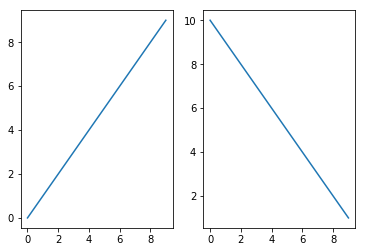

In [6]:
plt.subplot(121)
plt.plot(range(10))
plt.subplot(122) 
plt.plot(range(10, 0, -1));

* To plot two vectors $x$ and $y$ against each other:

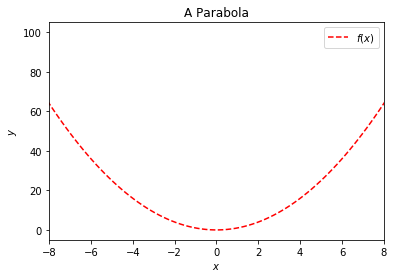

In [7]:
import numpy as np
x = np.linspace(-10, 10, 100)
y = x**2
plt.plot(x,y,'r--')  #Dashed red line; see table on p. 114.
plt.xlabel('$x$')  #LaTeX equations can be included by enclosing in $$.
plt.ylabel('$y$')
plt.title('A Parabola')
plt.legend(['$f(x)$'])  #Expects a list of strings.
plt.xlim(xmin=-8, xmax=8);  #Axis limits.
#plt.savefig('filename.svg')  #Save the plot to disk.

# Risk Measures
## Introduction
* The Basel Accords mandate that financial institutions report the risk associated with their positions, so that regulators may check the adequacy of the economic capital as a buffer against market risk.
* Reporting is in the form of a *risk measure*, which condenses the risk of a position into a single number.
* Currently, the mandated measure is *Value at Risk* (VaR), but there are debates of replacing it with an alternative (*Expected Shortfall*).
* Banks are allowed to use their own, internal models for the computation of VaR, but the adequacy of these models should be *backtested*.


## Value at Risk
* Consider a portfolio with value $V_{t}$ and daily (simple) return $R_{t}$.
* Define the one-day loss on the portfolio as

$$
\$Loss_{t+1}=-\left[V_{t+1}-V_{t}\right].
$$

* I will distinguish between the dollar Value at Risk (an amount) and the return Value at Risk (a percentage). When unqualified, I mean the latter.
* The one-day $100p\%$ dollar Value at Risk
$\$VaR_{t+1}^{p}$ is the loss on the portfolio that we are $100\left(1-p\right) \%$ confident will not be exceeded. The Basel committee prescribes $p=0.01$.

* The *return Value at risk* $VaR_{t+1}^{p}$ expresses
$\$VaR_{t+1}^{p}$
as a percentage of the portfolio value:

$$
VaR_{t+1}^{p}=\frac{\$VaR_{t+1}^{p}}{V_{t}}.
$$
* Hence
$$
\Pr (R_{t+1}<-VaR_{t+1}^{p})=p,
$$
because
$$
R_{t+1}=-\frac{\$Loss_{t+1}}{V_{t}}.
$$
This holds approximately for log returns, too.

* Thus $VaR_{t+1}^{p}$ is minus the $100p$th *percentile* (or minus the $p$th *quantile*) of the return distribution.

In [8]:
from matplotlib.patches import Polygon
import scipy.stats as stats  #The book likes to import it as `scs`.
a, b, c = -5, 5, stats.norm.ppf(0.05)
x = np.linspace(a, b, 100)
y = stats.norm.pdf(x)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
plt.plot(x, y, 'b', linewidth=2)
plt.ylim(ymin=0)
plt.xlim(xmin=a, xmax=b)
Ix = np.linspace(a, c)
Iy = stats.norm.pdf(Ix)
verts = [(a, 0)] + list(zip(Ix, Iy)) + [(c, 0)]
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
ax.add_patch(poly)
ax.annotate('$p\%$', xy=(-2, 0.025), xytext=(-3, 0.1),
            arrowprops=dict(width=.5),
            )
plt.xlabel('$R_{t+1}$')
plt.ylabel('$f(R_{t+1})$')
ax.set_xticks([c, 0])
ax.set_xticklabels(['$-VaR_{t+1}^p$', '0'])
ax.set_yticks([])
plt.savefig('img/var.svg')
plt.close()

<img src="img/var.svg" alt="VaR" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## Asset Returns: Stylized Facts
* Stylized facts about asset returns include
  * Lack of autocorrelation;
  * Leverage effects;
  * Heavy tails of return distribution;
  * Volatility clustering.
  
* These need to be taken into account when creating VaR forecasts. 


In [9]:
import pandas as pd
import pandas_datareader.data as web
import scipy.stats as stats  #The book likes to import it as `scs`.
p = web.DataReader("^GSPC", 'yahoo', start='1/1/2013', end='10/12/2017')['Adj Close']
r = np.log(p)-np.log(p).shift(1)
r.name = 'Return'
r = r[1:]  #Remove the first observation (NaN).
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.distplot(r, kde=False, fit=stats.norm)  #Histogram overlaid with a fitted normal density.
plt.subplot(122)
r.plot()  #Note that this is a pandas method! It looks prettier than plt.plot(r).
plt.savefig('img/stylizedfacts.svg')  #Save to file.
plt.close()

<img src="img/stylizedfacts.svg" alt="Stylized Facts" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## VaR Methods: Unconditional
### Non-parametric: Historical Simulation

* Historical simulation assumes that the distribution of tomorrow's portfolio
return is well approximated by the empirical distribution (histogram) of
the past $N$ observations $\left\{
R_{t}, R_{t-1},\ldots, R_{t+1-N}\right\} $.

* This is as if we draw, with replacement, from the last $N$ returns and use
this to simulate the next day's return distribution.

* The estimator of VaR is given by minus the $p$th *sample quantile* of the last $N$ portfolio returns, i.e., $\widehat{VaR}_{t+1}^{p}=-R^N_{p}$, where $R^N_{p}$ is the number such that $100p\%$ of the observations are smaller than it.


* In Python, we can use NumPy's `quantile` method, or the `percentile` function (or `nanpercentile` which ignores `NaN`s). Hilpisch uses `scoreatpercentile`, but that is is deprecated.

In [10]:
VaR_hist = -r.quantile(.01)  #Alternatively, VaR=np.percentile(r,1).
VaR_hist

0.02131716077914799

In [11]:
ax = r.hist(bins=30)  #Another pandas method: histogram with 30 bins.
ax.set_xticks([-VaR_hist])
ax.set_xticklabels(['$-VaR_{t+1}^{0.01}$ = -%4.3f' %VaR_hist])  #4.3f means floating point with 4 digits, of which 3 decimals.
plt.title('Historical VaR')
plt.savefig('img/var_hist.svg')
plt.close()

<img src="img/var_hist.svg" alt="VaR_hist" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* Problem: Last year(s) of data are not necessarily representative for the next few days (because of, e.g., volatility clustering).
* Exacerbated by the fact that a large $N$ is required to compute the 1% VaR with any degree of precision (only 1% of the data are really used).

### Parametric: Normal and $t$ Distributions
* Another simple approach is to
assume $R_{t+1}\sim N(\mu ,\sigma ^{2})$, and to estimate $\mu $
and $\sigma ^{2}$ from historical data (for daily data, $\mu \approx 0$). The VaR is then determined from

\begin{align*}
\Pr \left( R_{t+1}<-VaR_{t+1}^{p}\right) &=\Pr \left( \frac{R_{t+1}-\mu }{
\sigma }<\frac{-VaR_{t+1}^{p}-\mu }{\sigma }\right) \\
&=\Pr \left( z_{t+1}<\frac{-VaR_{t+1}^{p}-\mu }{\sigma }\right) \\
&=\Phi \left( \frac{-VaR_{t+1}^{p}-\mu }{\sigma }\right) =p,
\end{align*}

where $\Phi (z)$ is the cumulative standard normal distribution.

* Thus,
$$
VaR_{t+1}^{p}=-\mu -\sigma \Phi^{-1}(p),
$$
where $\Phi ^{-1}(p)$ is the inverse distribution function of the standard normal, a.k.a. the *percentage point function* (ppf).
* In Python:

In [12]:
mu, sig = stats.norm.fit(r)  #Fit a normal distribution to `r`.
VaR_norm = -mu-sig*stats.norm.ppf(0.01)
VaR_norm

0.01725813122968127

In [13]:
ax = sns.distplot(r, kde=False, fit=stats.norm)  #Histogram overlaid with a fitted normal density.
ax.set_xticks([-VaR_norm])
ax.set_xticklabels(['$-VaR_{t+1}^{0.01}$ = -%4.3f' %VaR_norm])
ax.text(0.02,60,'$\mu=%7.6f$\n$\sigma=%7.6f$' %(mu, sig))  #\n means newline.
plt.title('Normal VaR')
plt.savefig('img/var_norm.svg')
plt.close()

<img src="img/var_norm.svg" alt="VaR_norm" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* Problems:
  * The variance of the past year(s) of data is not necessarily representative for the future.
  * Returns typically have heavier tails than the normal.
* The solution to the second point is to use another distribution. The Student's $t$ distribution is a popular choice.

* The Student's $t$ distribution with $\nu$ degrees of freedom, $t_\nu$, is well known from linear regression
as the distribution of $t$-statistics. In that context, $\nu=T-k$, where $T$ is sample size and $k$ the number of regressors.

* It can be generalized to allow $\nu\in\mathbb{R}_+$.

* Smaller values of $\nu$ correspond to heavier tails. As $\nu\rightarrow \infty $, we approach the $N(0,1)$ distribution.

* It only has moments up to but not including $\nu$:
  * The mean is finite and equal to zero if $\nu>1$.
  * The variance is finite and equal to $\nu/(\nu-2)$ if $\nu>2$.
  * The excess kurtosis is finite and equal to $6/(\nu-4)$ if $\nu>4$.

* The distributions are symmetric around $0$, so the mean and skewness are $0$ if they exist.


In [14]:
x = np.linspace(-6, 6, 200)
df=[1, 2, 3, 10]
for nu in df:
    plt.plot(x, stats.t.pdf(x, nu))
legend = ['$\\nu=%1.0f$' % nu for nu in df]  #Double escaping: \\nu, not \nu, because \n is newline.
plt.plot(x, stats.norm.pdf(x))
legend.append('Normal')
plt.legend(legend)
plt.title("Student's $t$ Densities")
plt.xlabel('x')
plt.ylabel('$f_{\\nu}(x)$')
plt.savefig('img/tdists.svg')
plt.close()

<img src="img/tdists.svg" alt="t distributions" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* For financial applications, we need to allow for a non-zero mean, and a variance different from $\nu/(\nu-2)$.
* This is achieved by introducing a *location parameter* $m$ and a *scale parameter* $h$. We'll write $f_\nu(x;m,h)$ for the resulting density, $F_\nu(x;m,h)$ for the distribution function, and $F^{-1}_\nu(p;m,h)$ for the percentage point function.
* Note that if $x\sim t_\nu(m,h)$, $\nu>2$, then $\mathbb{E}[x]=m$ and $\mathrm{var}[x]=h^2\nu/(\nu-2)$.
* The VaR becomes
\begin{equation*}
VaR_{t+1}^{p}=-F^{-1}_\nu(p; m, h).
\end{equation*}
* In Python:

In [15]:
df, m, h = stats.t.fit(r)  #Fit a location-scale t distribution to r.
VaR_t = -stats.t.ppf(0.01, df, loc=m, scale=h)
VaR_t

0.021244827811891447

In [16]:
ax = sns.distplot(r, kde=False, fit=stats.t)  #Histogram overlaid with a fitted t density.
ax.set_xticks([-VaR_t])
ax.set_xticklabels(['$-VaR_{t+1}^{0.01}$ = -%4.3f' %VaR_t])
ax.text(0.02,60,'$m=%7.6f$\n$h=%7.6f$\n$\\nu=%7.6f$' %(m, h, df))
plt.title("Student's $t$ VaR")
plt.savefig('img/var_t.svg')
plt.close()

<img src="img/var_t.svg" alt="VaR_t" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* There are several ways to assess whether a distributional assumption is adequate.
* One is to use a *goodness of fit test*. Many such tests exist.
* Hilpisch discusses the D'Agostino-Pearson test, available as `stats.normaltest`.
* Here we use the Jarque-Bera test. The test statistic is
$$
JB=N\left(S^2/6+(K-3)/24\right),
$$
where $N$ is the sample size, and $S$ and $K$ are respectively the sample skewness and kurtosis.
* Intuitively, it tests that the skewness and excess kurtosis are zero.
* It is distributed as $\chi^2_2$ under the null of normality. The 5% critical value is 

In [17]:
stats.chi2.ppf(0.95, 2)

5.9914645471079799

* In Python:

In [18]:
stats.jarque_bera(r)  #Returns (JB, p-val).

(410.77889237295716, 0.0)

* Another option is to use a QQ-plot (quantile-quantile plot).
* It plots the empirical quantiles against the quantiles of a hypothesized distribution, e.g. $\Phi^{-1}(p)$ for the normal.
* If the distributional assumption is correct, then the plot should trace out the 45 degree line.

In [19]:
#This is the manual way to do it.
x = np.linspace(.01,.99)
emp = r.quantile(x)
mu, sig = stats.norm.fit(r)
theo = stats.norm.ppf(x, mu, sig)
ax = plt.plot(theo, emp.values, 'o')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot vs. Normal')
plt.savefig('img/qq_norm.svg')
plt.close()

<img src="img/qq_norm.svg" alt="QQ Plot" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

In [20]:
#this is a bit simpler.
sm.qqplot(r, dist=stats.t, fit=True)
plt.title("QQ Plot vs. Student's $t$")
plt.savefig('img/qq_t.svg')
plt.close()

<img src="img/qq_t.svg" alt="QQ Plot" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## VaR Methods: Filtered

* All methods discussed so far share one drawback: they assume that the volatility is constant, at least in the estimation (and forecast) period. 
* Implicitly, the Normal and Student's $t$ method use the *historical volatility*: 
$$
\sigma _{t+1,HIST}^{2}=\frac{1}{N}\sum_{j=0}^{N-1}R_{t-j}^{2}.
$$
(Note: volatility usually means standard deviation, not variance. I'll be sloppy here).
* Here we assumed a zero mean, which is realistic for daily returns.
* Some adaptability is gained by choosing a smaller $N$ such as 250 (one trading year), but there is a tradeoff because doing so decreases the sample size.
* A general solution requires a *volatility model*, which will be discussed in *Advanced Risk Management*.

* A Pandas `Series` object has a `rolling` method that can be used to construct historial volatilities for an entire series, using, at each day, the past $N$ observations.
* The method returns a special window object that in turn has a method `var` (for variance).

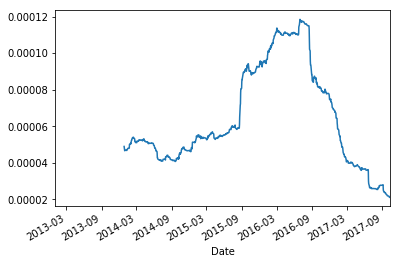

In [21]:
sig2_hist = r.rolling(window=250).var()
sig2_hist.plot();

* A partial solution to the drawbacks of historical volatility is given by the RiskMetrics model, which is a special case of a more general framework known as *GARCH* models.
* The idea is to replace the equally weighted moving average used in historical volatility by an exponentially weighted moving average (EWMA):

\begin{align*}
\sigma _{t+1,EWMA}^{2} &=(1-\lambda )\sum_{j=0}^{\infty }\lambda
^{j}R_{t-j}^{2} \\
&=\lambda \sigma _{t,EWMA}^{2}+(1-\lambda )R_{t}^{2},\qquad 0<\lambda <1.
\end{align*}

* This means that observations further in the past get a smaller weight.

* Smaller $\lambda$ means faster downweighting; for $\lambda\rightarrow 1$ we approach historical volatility (with an expanding window). For daily data, RiskMetrics recommends $\lambda =0.94$.

* In practice we do not have $R_{t-\infty }$, but the second equation
can be started up by an initial estimate / guess $\sigma _{0,EWMA}^{2}$.

* The `ewm` (exponentially moving average) method of a Pandas `Series` can be used to achieve something similar (the exact definition is slightly different, see [here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows)).
* As before, the method returns a window object that has a  `var` method.

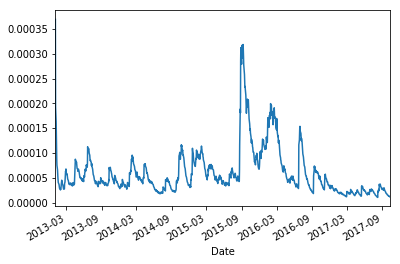

In [22]:
sig2_ewma = r.ewm(alpha=0.06).var()  #alpha=(1-lambda).
sig2_ewma.plot();

* The idea behind a filtered VaR method is to decompose the returns as 
$$
R_t=\mu+\sigma_t z_t, \quad z_t\stackrel{\mathrm{\small i.i.d}}{\sim}(0,1),
$$
so that $\mathbb{E}[R_t]=\mu$ and $\mathrm{var}[R_t]=\sigma^2_t$. In principle, $\mu$ could be time-varying as well.
* Let $z_{p}$ denote the $100p\%$ percentile of  
$$
z_t=\frac{R_t-\mu}{\sigma_t}.
$$
It can be estimated by applying any of the VaR methods above (historical, normal, or Student's t) to the *filtered* (demeaned and devolatized) returns
$$
\hat{z}_t=\frac{R_t-\hat{\mu}}{\hat{\sigma}_t}.
$$
* Finally, $VaR_{t+1}^p=-\mu-\sigma_{t+1} z_{p}$.

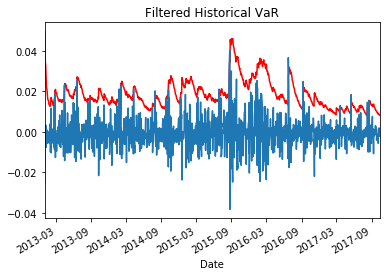

In [23]:
sig_ewma = np.sqrt(sig2_ewma)
mu = np.mean(r)
z = (r-mu)/sig_ewma
VaR_filtered_hist = -mu-sig_ewma*z.quantile(0.01)
VaR_filtered_hist.plot(color='red')
plt.plot(-r)
plt.title('Filtered Historical VaR');

## Backtesting
* The Basel accords require that banks' internal VaR models be *backtested*.

* They recommend constructing the 1% VaR over the last 250 trading days
and counting the number of *VaR exceptions* (times that losses exceeded the day's VaR figure).

* A method is said to lie in the:

  * Green zone, in case of 0-4 exceptions;
  * Yellow zone, in case of 5-9 exceptions;
  * Red zone, in case of 10 or more exceptions.
* Being in one of the latter two incurs an extra capital charge.

* A more advanced method is the *dynamic quantile* (DQ) test by Engle and Manganelli (2004).
* It is based on the *hit series*
$$
I_{t}=\left\{
\begin{array}{cc}
1, & \text{if }r_{t}<-VaR_{t}^{p}, \\
0, & \text{if }r_{t}>-VaR_{t}^{p}.
\end{array}
\right.
$$
* If the VaR model is correctly specified, then $\mathbb{E}[I_t]=p$ (there should be $p\cdot N$ exceptions in a sample of size $N$, on average). This is known as the *unconditional coverage hypothesis*.
* It can be tested by regressing $I_t-p$ on an intercept and testing that it is zero.
* In addition, it is desirable that the exceptions not be correlated. This is the *independence hypothesis*. It can be tested by including lags of $I_t$ in the regression and testing their significance.
* Jointly testing both (with an $F$ test) tests the *conditional coverage* hypothesis.

In [24]:
import statsmodels.formula.api as smf
y = (r < -VaR_filtered_hist)*1  #Multiplication by 1 turns True/False into 1/0.
y.name='I'
data = pd.DataFrame(y)
model = smf.ols('I.subtract(0.01)~I.shift(1)', data=data)
res = model.fit()
print(res.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.020     
Dependent Variable: I.subtract(0.01) AIC:                -2069.9720
Date:               2017-11-23 14:41 BIC:                -2059.7852
No. Observations:   1204             Log-Likelihood:     1037.0    
Df Model:           1                F-statistic:        25.67     
Df Residuals:       1202             Prob (F-statistic): 4.68e-07  
R-squared:          0.021            Scale:              0.010475  
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
Intercept    -0.0008     0.0030   -0.2576   0.7967   -0.0066   0.0051
I.shift(1)    0.1446     0.0285    5.0669   0.0000    0.0886   0.2006
-------------------------------------------------------------------
Omnibus:            1816.402      Durbin-Watson:        

* Conclusions:
  * Unconditional coverage is not rejected. This is by construction; note that $r_{t}\lessgtr-VaR_{t}^{p}\Longleftrightarrow z_t\lessgtr z_p$.
  * Independence is rejected; apparently our model is dynamically mis-specified. We may need to use a more general GARCH model instead of EWMA.
* The latter finding is likely driving the rejection of the conditional coverage test:
  

In [25]:
print(res.f_test('Intercept=0, I.shift(1)=0'))

<F test: F=array([[ 12.87315967]]), p=2.93962494772e-06, df_denom=1202, df_num=2>
